In [95]:
from astropy.modeling import models, fitting
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
#from dendrocat.aperture import Ellipse
from matplotlib.patches import Rectangle, Ellipse
import regions
from scipy.optimize import curve_fit
from regions import EllipseAnnulusSkyRegion, EllipseAnnulusPixelRegion, EllipsePixelRegion
import Paths.Paths as paths
from regions.core import PixCoord
from astropy.stats import mad_std
from matplotlib import colors
from astropy.io import ascii

Path = paths.filepaths()







In [96]:
class core_catdata():
    def __init__(self,catfile, almaimf_beam,  start_coreno, hrfits=None,band='B3', recommend_criteria = 'b6', include_ff='all' ):
        catdata_w51e = ascii.read(catfile,data_start=0,format='commented_header', header_start=120,  comment="!")
        geo_avg_beam = np.sqrt(almaimf_beam.major.to(u.arcsec).value*almaimf_beam.minor.to(u.arcsec).value)
        corr_factor = catdata_w51e['AFWHM02'] * catdata_w51e['BFWHM02'] / catdata_w51e['AFWHM03'] / catdata_w51e['BFWHM03']
        numcore_tot = len(catdata_w51e['AFWHM02'])
        if include_ff=='all':
            coreno_merged = start_coreno[0] + start_coreno[1]
            print('coreno_merged',coreno_merged)
            coreno_merged.sort()
            coreno_start = coreno_merged
            print('coreno_start',coreno_start)
        elif include_ff=='ffonly':
            coreno_start = start_coreno[1]
        elif include_ff=='no':
            coreno_start = start_coreno[0]
        coreidx_start = [i for i in range(numcore_tot) if catdata_w51e['NO'][i] in coreno_start]
        if recommend_criteria == 'b6b3':
            coreidx = [idx for idx in coreidx_start if all([np.abs(catdata_w51e['GOODM02'][idx])>1,  
                       np.abs(catdata_w51e['SIGNM02'][idx])>1,  
                       catdata_w51e['FXP_BST02'][idx]/catdata_w51e['FXP_ERR02'][idx]>2, 
                       catdata_w51e['FXT_BST02'][idx]/catdata_w51e['FXT_ERR02'][idx]>2, 
                       catdata_w51e['AFWHM02'][idx]/catdata_w51e['BFWHM02'][idx]<2 ,
                        catdata_w51e['FOOA02'][idx]/catdata_w51e['AFWHM02'][idx]>1.15 ,
                        np.sqrt(catdata_w51e['AFWHM03'][idx]*catdata_w51e['BFWHM03'][idx]) <4 * geo_avg_beam  ,
                        catdata_w51e['AFWHM03'][idx]/catdata_w51e['BFWHM03'][idx]<=2 ,
                        np.abs(catdata_w51e['SIGNM03'][idx])>1 ,
                        catdata_w51e['FXP_BST03'][idx]/catdata_w51e['FXP_ERR03'][idx]>1,  
                        catdata_w51e['FXT_BST03'][idx]/catdata_w51e['FXT_ERR03'][idx]>1])]
        elif recommend_criteria == 'b6':
            coreidx = coreidx_start                  
       
        
        if hrfits is not None:
            yso_image = fits.open(hrfits)[0].data[0][0]
            hrhdr = fits.open(hrfits)[0].header
            inside_idx = exist_inside_FOV(catdata_w51e['WCS_ACOOR'], catdata_w51e['WCS_DCOOR'], yso_image, hrhdr)
    
            rec_ind = np.intersect1d(coreidx, inside_idx)
        else:
            rec_ind = coreidx
        print('total core number = ', len(catdata_w51e['WCS_ACOOR']))
        print(hrfits)
        print('robust %s measurement before applying FoV criteria = '%band, len(coreidx))
        print('robust %s measurement after applying FoV criteria = '%band, len(rec_ind))
       
        self.sky_ra = catdata_w51e['WCS_ACOOR'][rec_ind]
        self.sky_dec = catdata_w51e['WCS_DCOOR'][rec_ind]
        self.pix_x = catdata_w51e['XCO_P'][rec_ind]
        self.pix_y = catdata_w51e['YCO_P'][rec_ind]
        
        if band=='B3':
            bandind = 3
        else:
            bandind = 2

        self.afwhm = catdata_w51e['AFWHM0%d'%bandind][rec_ind] #arcsec
        self.bfwhm = catdata_w51e['BFWHM0%d'%bandind][rec_ind]

        self.asize = catdata_w51e['ASIZE0%d'%bandind][rec_ind]
        self.bsize = catdata_w51e['BSIZE0%d'%bandind][rec_ind]

        self.theta = catdata_w51e['THETA0%d'%bandind][rec_ind]
        
        self.flux = catdata_w51e['FXT_BST0%d'%bandind][rec_ind]
        self.fluxerr = catdata_w51e['FXT_ERR0%d'%bandind][rec_ind]
        self.flux_g = catdata_w51e['FXT_ALT0%d'%bandind][rec_ind]

        self.fooa = catdata_w51e['FOOA0%d'%bandind][rec_ind]
        self.foob = catdata_w51e['FOOB0%d'%bandind][rec_ind]
        
        self.int_peak = catdata_w51e['FXP_BST0%d'%bandind][rec_ind]
        self.interr_peak = catdata_w51e['FXP_ERR0%d'%bandind][rec_ind]
        
        self.size = (catdata_w51e['AFWHM0%d'%bandind][rec_ind]*catdata_w51e['BFWHM0%d'%bandind][rec_ind]**2)**(1/3) #arcsec


        self.no = catdata_w51e['NO'][rec_ind]

        
        
        rescaled_3mmflux = catdata_w51e['FXT_BST03'][rec_ind] * catdata_w51e['AFWHM02'][rec_ind] * catdata_w51e['BFWHM02'][rec_ind] / catdata_w51e['AFWHM03'][rec_ind]/catdata_w51e['BFWHM03'][rec_ind]
        gamma = np.log10(catdata_w51e['FXT_BST02'][rec_ind] / rescaled_3mmflux)/np.log10(228.918/101.426)
        self.woffind = np.where(gamma>2)[0]
        self.wffind = np.where(gamma<2)[0]
        self.rec_ind = rec_ind

        
    def get_temperature(self,tempfile,temp100ind = [], temp300ind =[]):
        #temp100ind = hot cores with 100K
        #temp300ind = hot cores with 300K

        tab = ascii.read(tempfile, data_start=4)
        id = tab['col1']
        ra = tab['col2']
        dec = tab['col3']
        temp = tab['col4']

        """
        for i in range(len(self.sky_ra)):
            dist = np.sqrt((self.sky_ra[i]-ra)**2+(self.sky_dec[i]-dec)**2) #deg
            mindist = np.min(dist)
            if mindist<threshold:
                index = np.argmin(dist)
                temparr.append(temp[index])
            else:
                temparr.append(np.nan)
        """
        temparr = np.array([temp[np.where(id==no)[0]][0] for no in self.no])
        for i in range(len(temp100ind)):
            if temp100ind[i] in self.no:
                idx100 = np.where(self.no==temp100ind[i])[0]
                print(idx100)
                temparr[idx100] = 100
                print('#%d core temp -->100K'%temp100ind[i])
        for i in range(len(temp300ind)):
            if temp300ind[i] in self.no:
                idx300 = np.where(self.no==temp300ind[i])[0]
                temparr[idx300] = 300
                print('#%d core temp -->300K'%temp300ind[i])
        self.temp = np.array(temparr)*u.K
        
        return self.temp
    
    def get_tau(self, freq, omega):
        bb = models.BlackBody(temperature=self.temp)
    
        peak_int = (self.int_peak * u.Jy/u.beam).to(u.Jy/u.sr, equivalencies=u.beam_angular_area(omega))

        return -np.log(1 - (peak_int/ bb(freq).to(u.Jy/u.sr)).to(u.cm/u.cm).value)
    
    def get_coremass(self, freq, kappa, dist,omega):
            
        print('self.temp',self.temp)
        bb = models.BlackBody(temperature=self.temp)
        peak_int = (self.int_peak * u.Jy/u.beam).to(u.Jy/ u.sr, equivalencies=u.beam_angular_area(omega))
        print('peak_int',peak_int)
        print('self.flux',self.flux)
        print('kappa',kappa)
        print(bb(freq).to(u.Jy/u.sr))
        mass = - 1 / kappa * dist**2 * self.flux * u.Jy/ u.sr / peak_int * np.log(1 - (peak_int/ bb(freq).to(u.Jy/u.sr)).to(u.cm/u.cm).value)
        print((peak_int/ bb(freq).to(u.Jy/u.sr)).to(u.cm/u.cm).value)
        print(mass)
        print('mass',mass.to(u.Msun))
        self.mass = mass.to(u.Msun)
        return mass.to(u.Msun)
    
    def get_coremasserr(self):
        
        masserr = np.abs(self.mass * np.sqrt((self.fluxerr/self.flux)**2+(self.interr_peak/self.int_peak)**2))
        self.masserr = masserr
        return masserr.to(u.Msun)
                       
    def get_Jeansmass(self, dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3) #arcsec -> au
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)
        c_s = np.sqrt(c.k_B*self.temp/2.8/c.m_p)
        jeans_mass = np.pi**(5/2)/6/c.G**(3/2) * c_s.to(u.cm/u.s)**3 * rho.to(u.g/u.cm**3)**(-1/2)
        
        return jeans_mass.to(u.Msun)

    def get_Jeansmasserr(self,dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3) #arcsec -> au
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)
        c_s = np.sqrt(c.k_B*self.temp/2.8/c.m_p)
        jeans_mass = np.pi**(5/2)/6/c.G**(3/2) * c_s.to(u.cm/u.s)**3 * rho.to(u.g/u.cm**3)**(-1/2)
        rho_err = self.masserr / (4/3*np.pi * (rad*u.au)**3)

        jeans_mass_err = 0.5*jeans_mass * (rho_err/rho)

        return jeans_mass_err.to(u.Msun)
    def get_BE_mass(self, dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3)
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)

        BE_mass = 1.18 * np.sqrt((c.k_B*self.temp/2.33/c.m_p/c.G)**3/rho).to(u.Msun)
        return BE_mass.to(u.Msun)
    
    def get_BE_masserr(self, dist=5400):
        rad = (self.afwhm.value*dist * self.bfwhm.value**2*dist**2)**(1/3)
        rho = self.mass / (4/3*np.pi * (rad*u.au)**3)

        BE_mass = 1.18 * np.sqrt((c.k_B*self.temp/2.33/c.m_p/c.G)**3/rho).to(u.Msun)
        rho_err = self.masserr / (4/3*np.pi * (rad*u.au)**3)

        BE_mass_err = 0.5*BE_mass * (rho_err/rho)
        return BE_mass_err.to(u.Msun)
    
    
    def multiplicity(self, hdrhr, xysource, almaimf_beam=None,issky=True, label=None, aperture='fwhm+beam',limitarea=None,  maxrad=1e3, verbose=False):
        ncat = len(self.no)
        if limitarea is not None:
            posind = np.where((sky_ra>limitarea[0])&(sky_ra<limitarea[1])&
                              (sky_dec>limitarea[2])&(sky_dec<limitarea[3]))[0]
        else:
            posind = np.arange(ncat)
        if label is None:
            label=np.arange(ncat)
        coreidx = np.arange(ncat)

        totalind = np.intersect1d(posind, label)
        print('totalind',totalind)
        sky_ra = self.sky_ra[totalind]
        sky_dec = self.sky_dec[totalind]
        fooa = self.fooa[totalind]
        foob = self.foob[totalind]
        theta = self.theta[totalind]
        no = self.no[totalind]
        afwhm =self.afwhm[totalind]
        bfwhm = self.bfwhm[totalind]

        skypos = np.vstack((sky_ra,sky_dec)).T


        wcshr = WCS(hdrhr,naxis=2)
        scalehr = wcshr.proj_plane_pixel_scales()[0]

        xypos_core = wcshr.wcs_world2pix(skypos,0)
        xpos_core = xypos_core[:,0]
        ypos_core = xypos_core[:,1]

        if issky:
            xysource_pix = wcshr.wcs_world2pix(xysource,0)
        else:
            xysource_pix = xysource
        ysonumarr=[] ; coreindarr=[]; ysoindarr=[]
        prestellar_ind = []
        protostellar_ind = []
        #print(xysource)
        for i in range(len(xypos_core)):
            if aperture is 'footprint':
                major = fooa[i]/3600/scalehr.value
                minor = foob[i]/3600/scalehr.value
                pa = theta[i]+90
            elif aperture is 'fwhm+beam':
                meanbeamsize = (almaimf_beam.major.value+almaimf_beam.minor.value)/4
                major = (afwhm[i]/3600+meanbeamsize)/scalehr.value
                minor = (bfwhm[i]/3600+meanbeamsize)/scalehr.value
                pa = theta[i]+90
            elif aperture is 'beam':
                major = almaimf_beam.major.value/scalehr.value
                minor = almaimf_beam.minor.value/scalehr.value
                pa = almaimf_beam.pa.value+90
            #if major > maxrad:
            #    continue

            numsource, indsource = count_points_in_ellipse(xpos_core[i],ypos_core[i],major,minor,pa,xysource_pix[:,0],xysource_pix[:,1])
            print(totalind[i], indsource, numsource)
            ysonumarr.append(numsource)
            coreindarr.append(totalind[i])
            ysoindarr.append(indsource)
            if numsource==0:
                prestellar_ind.append(totalind[i])
            elif numsource>0:
                protostellar_ind.append(totalind[i])
            
            
      
        ysoindarr_flat = []
        for arr in ysoindarr:
            ysoindarr_flat.extend(arr)
       
        print('cores with/without YSOs ', len(np.where(np.array(ysonumarr)!=0)[0]), len(xpos_core)-len(np.where(np.array(ysonumarr)!=0)[0]))
        print('YSOs associated with cores',len(np.unique(ysoindarr_flat)),' out of ',len(xysource_pix[:,0]))
              
        self.ysonumarr = ysonumarr
        self.coreindarr = coreindarr
        self.ysoindarr = ysoindarr
        self.prestellar_ind = prestellar_ind
        self.protostellar_ind = protostellar_ind
        print('pre,pro',self.prestellar_ind, self.protostellar_ind)
        return ysonumarr, coreindarr, ysoindarr, prestellar_ind, protostellar_ind
        
def bbox_contains_bbox(bbox1,bbox2):
    """returns true if bbox2 is inside bbox1"""
    return ((bbox1.ixmax>bbox2.ixmax) & (bbox1.ixmin<bbox2.ixmin) &
            (bbox1.iymax>bbox2.iymax) & (bbox1.iymin<bbox2.iymin))

def sub_bbox_slice(bbox1, bbox2):
    """returns a slice from within bbox1 of bbox2"""
    if not bbox_contains_bbox(bbox1, bbox2):
        raise ValueError("bbox2 is not within bbox1")
    x0, dx = bbox2.ixmin-bbox1.ixmin, bbox2.ixmax-bbox2.ixmin
    y0, dy = bbox2.iymin-bbox1.iymin, bbox2.iymax-bbox2.iymin
    return (slice(y0, y0+dy), slice(x0, x0+dx),)

def slice_bbox_from_bbox(bbox1, bbox2):
    """
    Utility tool. Given two bboxes in the same coordinates, give the views of
    each box corresponding to the other.  For example, if you have an image
    ``im`` and two overlapping cutouts from that image ``cutout1`` and
    ``cutout2`` with bounding boxes ``bbox1`` and ``bbox2``, the returned views
    from this function give the regions ``cutout1[view1] = cutout2[view2]``
    """

    if bbox1.ixmin < bbox2.ixmin:
        blcx = bbox2.ixmin
    else:
        blcx = bbox1.ixmin
    if bbox1.ixmax > bbox2.ixmax:
        trcx = bbox2.ixmax
    else:
        trcx = bbox1.ixmax
    if bbox1.iymin < bbox2.iymin:
        blcy = bbox2.iymin
    else:
        blcy = bbox1.iymin
    if bbox1.iymax > bbox2.iymax:
        trcy = bbox2.iymax
    else:
        trcy = bbox1.iymax

    y0_1 = max(blcy-bbox1.iymin,0)
    x0_1 = max(blcx-bbox1.ixmin,0)
    y0_2 = max(blcy-bbox2.iymin,0)
    x0_2 = max(blcx-bbox2.ixmin,0)

    dy_1 = min(bbox1.iymax-blcy,trcy-blcy)
    dx_1 = min(bbox1.ixmax-blcx,trcx-blcx)
    dy_2 = min(bbox2.iymax-blcy,trcy-blcy)
    dx_2 = min(bbox2.ixmax-blcx,trcx-blcx)

    view1 = (slice(y0_1, y0_1+dy_1),
             slice(x0_1, x0_1+dx_1),)
    view2 = (slice(y0_2, y0_2+dy_2),
             slice(x0_2, x0_2+dx_2),)
   
    for slc in view1+view2:
        assert slc.start >= 0
        assert slc.stop >= 0
   
    return view1,view2

def get_local_bkg(data, xcen, ycen, angle, peakxy_all, wcsNB, beam, pixel_scale, 
                  inner_width=1, outer_width=2, inner_height=1, outer_height=2, issky=False, filter_bright_pixels=False, plot=False, n_expected_neighbor=10):
    """
    Get the local background for a given source
    
    args
    -----
    data: 2D array

    xcen, ycen: float
        the pixel coordinates of source in the total image
    peakxy_all: 2D array
        the pixel coordinates of the peak of the source
    wcsNB: WCS
        the wcs of the image
    beam: radio_beam.Beam
        the beam of the image
    pixel_scale: astropy.unit
        the pixel scale of the image
    inner_width: float
        the inner width of the ellipse
    outer_width: float
        the outer width of the ellipse
    inner_height: float
        the inner height of the ellipse
    outer_height: float
        the outer height of the ellipse
    angle: astropy.unit
        the angle of the ellipse
    issky: bool
        issky is True if the input peakxy_all is in sky coordinates
    filter_bright_pixels: bool 
        filter_bright_pixels is True if you want to filter out the bright pixels in the source region
    
    return
    -------
    background: float
        the median of the background
    mad: float
        the median absolute deviation of the background
    """

    if isinstance(inner_width, u.Quantity):
        inner_width = inner_width.value
    if isinstance(outer_width, u.Quantity):
        outer_width = outer_width.value
    if isinstance(inner_height, u.Quantity):
        inner_height = inner_height.value
    if isinstance(outer_height, u.Quantity):
        outer_height = outer_height.value
    if isinstance(angle, u.Quantity):
        angle = angle.value

    
    bkg_region = EllipseAnnulusPixelRegion(center=PixCoord(x=xcen, y=ycen),
                                       inner_width=inner_width,
                                       outer_width=outer_width,
                                       inner_height=inner_height,
                                       outer_height=outer_height,
                                       angle=angle*u.deg)
    

    mask = bkg_region.to_mask()
    data_in_cutout = mask.cutout(data)
    masked_data = data_in_cutout * mask.data
    maskbool = mask.data.astype('bool')

    beam_major = beam.major
    beam_minor = beam.minor
    beam_pa = beam.pa

    # masking the position where other neighboring sources lie
    if peakxy_all is not None:

        dist = np.sqrt((peakxy_all[:,0]-xcen)**2+(peakxy_all[:,1]-ycen)**2)
        peakxy_sorted = peakxy_all[np.argsort(dist)]
        peakxy_sorted_selected = peakxy_sorted[:n_expected_neighbor]
    

        
        if issky:
            cen_pix = wcsNB.wcs_world2pix(peakxy_sorted_selected,0)
            cen_world = peakxy_sorted_selected
        else:
            cen_pix = peakxy_sorted_selected
            cen_world = wcsNB.wcs_pix2world(peakxy_sorted_selected,0)
    
  
        
        positions_all = coordinates.SkyCoord([[cen_world[i,0],cen_world[i,1]] for i in range(n_expected_neighbor)], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))

   
        test_region = EllipseAnnulusPixelRegion(center=PixCoord(x=xcen, y=ycen),
                                        outer_width=outer_width+beam_major.value/pixel_scale.value,
                                        inner_width=inner_width-beam_major.value/pixel_scale.value,
                                        outer_height=outer_height+beam_minor.value/pixel_scale.value,
                                        inner_height=inner_height-beam_minor.value/pixel_scale.value,
                                        angle=angle*u.deg)
        
        nearby_matches =[PixCoord(peakxy_sorted_selected[i,0],peakxy_sorted_selected[i,1]) in test_region for i in range(n_expected_neighbor)]
 
        if any(nearby_matches):
            
            inds = np.where(nearby_matches)[0].tolist()
            if len(inds)>1:
                dist = np.sqrt((peakxy_sorted_selected[inds,0]-xcen)**2+(peakxy_sorted_selected[inds,1]-ycen)**2)
                myself = np.argmin(dist)
                #print(inds, len(inds),myself)
                inds.remove(inds[myself])
                for ind in inds:
                    
                    maskoutreg = regions.EllipseSkyRegion(center=positions_all[ind], width=2*beam_major,
                                                            height=2*beam_minor,
                                                            angle=180*u.deg-beam.pa)
                    mpixreg = maskoutreg.to_pixel(wcsNB)
                    mmask = mpixreg.to_mask()
                    view, mview = slice_bbox_from_bbox(mask.bbox, mmask.bbox)
                    maskbool[view] &= ~mmask.data.astype('bool')[mview]
                    masked_data = masked_data * maskbool
    background_mask = maskbool.copy().astype('bool')
    #background_mask[sub_bbox_slice(mask.bbox, smaller_mask.bbox)] &= ~smaller_mask.data.astype('bool')
    masked_cutout = masked_data[background_mask]

    if filter_bright_pixels:
        source_region = EllipsePixelRegion(center=PixCoord(x=xcen, y=ycen),
                                       width=inner_width,
                                       height=inner_height,
                                       angle=angle)
        source_mask = source_region.to_mask()
        source_mask_cutout = source_mask.cutout(data)
        thres = np.min(source_mask_cutout)
       # print('thres',thres)
        masked_cutout = masked_cutout[np.where((masked_cutout<thres)&(np.isfinite(masked_cutout)))]
    background = np.nanmedian(masked_cutout)
    mad = mad_std(masked_cutout, ignore_nan=True)
    if plot:
        fig = plt.figure(figsize=(21,7))
        ax1 = fig.add_axes([0,0,0.33,1])
        ax2 = fig.add_axes([0.33,0,0.33,1])
        ax3 = fig.add_axes([0.66,0,0.33,1])
        ax1.imshow(data_in_cutout, origin='lower', cmap=plt.get_cmap('inferno'), norm=colors.PowerNorm(gamma=0.5,
                                            vmin=0,vmax=np.nanmax(masked_cutout)))
        artist = test_region.as_artist()
        ax1.add_artist(artist)
        ax2.imshow(maskbool,origin='lower', cmap=plt.get_cmap('inferno'))
        ax3.imshow(masked_data, origin='lower', cmap=plt.get_cmap('inferno'), norm=colors.PowerNorm(gamma=0.5, vmin=0, vmax=np.nanmax(masked_data)))
        plt.show()
        plt.close()
    
    
    return background, mad

def get_snr(data, peakx,peaky, peakxy_all, afwhm, bfwhm, angle, wcsNB, beam, pixel_scale ):
    snrarr=[]
    try:
        length = len(afwhm)
        isscalar=False
    except:
        isscalar=True
    if isscalar:
        xcen = peakx
        ycen = peakx
        if xcen<0 or xcen>data.shape[1] or ycen<0 or ycen>data.shape[0]:
            return 0
        else:
            afwhm = beam.major/pixel_scale
            bfwhm = beam.minor/pixel_scale
            bkg, mad = get_local_bkg(data, xcen, ycen, angle, peakxy_all, wcsNB, beam, pixel_scale,inner_width=2*afwhm, outer_width=3*afwhm, inner_height=2*bfwhm, outer_height=3*bfwhm)
            peak_pixel = data[int(ycen),int(xcen)]
            snr = (peak_pixel-bkg)/mad
            print('xcen,ycen, afwhm, bfwhm, peak_pixel, bkg, mad, snr',xcen,ycen, afwhm, bfwhm, peak_pixel, bkg, mad, snr)
            return snr
    

    else:
        for i in range(len(afwhm)):
            xcen = peakx[i]
            ycen = peaky[i]
            print(data.shape,xcen,ycen, afwhm[i], bfwhm[i], angle[i])
            if xcen<0 or xcen>data.shape[1] or ycen<0 or ycen>data.shape[0]:
                snr=0
            else:
                if not np.isfinite(afwhm[i]) or not np.isfinite(bfwhm[i]):
                    afwhm[i] = beam.major/pixel_scale
                    bfwhm[i] = beam.minor/pixel_scale
                bkg, mad = get_local_bkg(data, xcen, ycen, angle[i], peakxy_all, wcsNB, beam, pixel_scale,inner_width=2*afwhm[i], outer_width=3*afwhm[i], inner_height=2*bfwhm[i], outer_height=3*bfwhm[i])
                peak_pixel = data[int(ycen),int(xcen)]
                snr = (peak_pixel-bkg)/mad
            snrarr.append(snr)
        return np.array(snrarr)

def count_points_in_ellipse(xcen,ycen,major,minor,pa,xpos,ypos):
    # caclulate foci positions 
    # must be full major, minor not semi major, minor
    fodx = np.cos(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    fody = np.sin(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    
    fox1 = xcen + fodx
    foy1 = ycen + fody
    
    fox2 = xcen - fodx
    foy2 = ycen - fody
    
    dist1 = np.sqrt((xpos-fox1)**2+(ypos-foy1)**2)
    dist2 = np.sqrt((xpos-fox2)**2+(ypos-foy2)**2)
    
    isinside = np.where(dist1+dist2<major)[0]
    
    return len(isinside), list(isinside)



def exist_inside_FOV(xcore_sky, ycore_sky, yso_image, hrhdr):
    isfinite = np.where(np.isfinite(yso_image))
    xfinite1 = np.min(isfinite[0])
    xfinite2 = np.max(isfinite[0])
    yfinite1 = np.min(isfinite[1])
    yfinite2 = np.max(isfinite[1])
     
    xcen = (xfinite1 + xfinite2)/2
    ycen = (yfinite1 + yfinite2)/2

    wcs_hr = WCS(hrhdr,naxis=2)
    xypos = wcs_hr.wcs_world2pix(np.vstack((xcore_sky,ycore_sky)).T,0)
    
    rad = np.abs(xfinite2 - xcen)
    
    
    dist = np.sqrt((xypos[:,0]- xcen)**2+(xypos[:,1]-ycen)**2)
    isinside = np.where(dist<rad)[0]
    
    return isinside


In [97]:
fitsdata_b3 = fits.open(Path.w51e_b3_tt0)
image_b3_w51e = fitsdata_b3[0].data
if len(image_b3_w51e.shape)>2:
    image_b3_w51e = fitsdata_b3[0].data[0][0]
hdrB3_w51e_hr = fits.getheader(Path.w51e_b3_tt0) 
wcsB3_w51e_hr = WCS(hdrB3_w51e_hr,naxis=2)
scale_w51e_b3_hr = wcsB3_w51e_hr.proj_plane_pixel_scales()[0] 
beam_b3_w51e = Beam.from_fits_header(hdrB3_w51e_hr)
    
fitsdata_b3 = fits.open(Path.w51n_b3_tt0)
image_b3_w51n = fitsdata_b3[0].data
if len(image_b3_w51n.shape)>2:
    image_b3_w51n = fitsdata_b3[0].data[0][0]
hdrB3_w51n_hr = fits.getheader(Path.w51n_b3_tt0) 
wcsB3_w51n_hr = WCS(hdrB3_w51n_hr,naxis=2)
scale_w51n_b3_hr = wcsB3_w51n_hr.proj_plane_pixel_scales()[0]
beam_b3_w51n = Beam.from_fits_header(hdrB3_w51n_hr)

fitsdata_b6 = fits.open(Path.w51e_b6_cont)
image_b6_w51e = fitsdata_b6[0].data
if len(image_b6_w51e.shape)>2:
    image_b6_w51e = fitsdata_b6[0].data[0][0]
hdrB6_w51e_hr = fits.getheader(Path.w51e_b6_cont)  
wcsB6_w51e_hr = WCS(hdrB6_w51e_hr,naxis=2)
scale_w51e_b6_hr = wcsB6_w51e_hr.proj_plane_pixel_scales()[0]
beam_b6_w51e = Beam.from_fits_header(hdrB6_w51e_hr)

fitsdata_b6 = fits.open(Path.w51n_b6_cont)
image_b6_w51n = fitsdata_b6[0].data
if len(image_b6_w51n.shape)>2:
    image_b6_w51n = fitsdata_b6[0].data[0][0]
hdrB6_w51n_hr = fits.getheader(Path.w51n_b6_cont)  
wcsB6_w51n_hr = WCS(hdrB6_w51n_hr,naxis=2)
scale_w51n_b6_hr = wcsB6_w51n_hr.proj_plane_pixel_scales()[0]
beam_b6_w51n = Beam.from_fits_header(hdrB6_w51n_hr)


hdrB6_w51e_almaimf = fits.getheader(Path.w51e_b6_almaimf)  
wcsB6_w51e_almaimf = WCS(hdrB6_w51e_almaimf,naxis=2)
beamb6_w51e_almaimf = Beam.from_fits_header(hdrB6_w51e_almaimf)  
scale_w51e_almaimf = wcsB6_w51e_almaimf.proj_plane_pixel_scales()[0]


hdrB3_w51e_almaimf = fits.getheader(Path.w51e_b3_almaimf)  
wcsB3_w51e_almaimf = WCS(hdrB3_w51e_almaimf,naxis=2)
beamb3_w51e_almaimf = Beam.from_fits_header(hdrB3_w51e_almaimf) 

hdrB6_w51n_almaimf = fits.getheader(Path.w51n_b6_almaimf)  
wcsB6_w51n_almaimf = WCS(hdrB6_w51n_almaimf,naxis=2)
beamb6_w51n_almaimf = Beam.from_fits_header(hdrB6_w51n_almaimf)  

hdrB3_w51n_almaimf = fits.getheader(Path.w51n_b3_almaimf)  
wcsB3_w51n_almaimf = WCS(hdrB3_w51n_almaimf,naxis=2)
beamb3_w51n_almaimf = Beam.from_fits_header(hdrB3_w51n_almaimf) 

fitsdata_almaimf_w51e_b6 = fits.open(Path.w51e_b6_almaimf)
image_almaimf_w51e_b6 = fitsdata_almaimf_w51e_b6[0].data
if len(image_almaimf_w51e_b6.shape)>2:
    image_almaimf_w51e_b6 = fitsdata_almaimf_w51e_b6[0].data[0][0]

coreidx_w51e_fabien = [[2,4,8,11,12,13,14,15,16,17,19,21,22,26,28,29,33,34,38,39],[1,3,5,6,9,10,18,27]] #30, 31, 20 are discarded because they have duplicated pairs in IRS2
coreidx_w51n_fabien = [[1,2,4,6,7,8,9,10,11,12,13,14,15,16,17,19,20,22,23,24,25,26,27,28,29,31,32,33,34,35,37,38,40,41,42,43,44,45,46,47,48,
49,51,52,53,54,55,57,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,84,85,86,87,88,89,90,91,92,94,95,97,99,100,101,102,104,105,106,107,108,109,111,114,117,119,122,123],
[3,5,18,36,56,58,98,113,118,124]]

core_catdata_w51e_b6_b6crit_b3fov = core_catdata(Path.w51e_almaimf_catalog, beamb6_w51e_almaimf, coreidx_w51e_fabien, hrfits=Path.w51e_b3_tt0, band='b6')

xypos = np.vstack((core_catdata_w51e_b6_b6crit_b3fov.sky_ra,core_catdata_w51e_b6_b6crit_b3fov.sky_dec)).T
xypos_pix = wcsB6_w51e_almaimf.wcs_world2pix(xypos,0)
core_snr_w51e_b6 = get_snr(image_almaimf_w51e_b6, xypos_pix[:,0],xypos_pix[:,1], xypos_pix,
                            core_catdata_w51e_b6_b6crit_b3fov.afwhm/3600/scale_w51e_almaimf.value, core_catdata_w51e_b6_b6crit_b3fov.bfwhm/3600/scale_w51e_almaimf.value,
                              core_catdata_w51e_b6_b6crit_b3fov.theta.value, wcsB6_w51e_almaimf, beamb6_w51e_almaimf, scale_w51e_almaimf)



coreno_merged [2, 4, 8, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 26, 28, 29, 33, 34, 38, 39, 1, 3, 5, 6, 9, 10, 18, 27]
coreno_start [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 26, 27, 28, 29, 33, 34, 38, 39]
total core number =  41
/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits
robust b6 measurement before applying FoV criteria =  28
robust b6 measurement after applying FoV criteria =  26
(1920, 1920) 1025.4419905506618 1054.1493531716606 17.333333333329865 10.711666666664525 180.0
(1920, 1920) 1012.1576444425236 1054.0292943751092 18.449999999996308 10.974999999997802 177.4
(1920, 1920) 1519.142905393599 1423.96495759211 11.03166666666446 9.213333333331489 161.6
(1920, 1920) 1028.2945739354554 948.3393675401308 14.183333333330495 12.119999999997574 6.399
(1920, 1920) 1033.7075453428915 1077.897396447742 17.016666666663262 12.73833

In [98]:
catalog_w51e_yso = Table.read(Path.w51e_dendro_matched_catalog ,format='fits')
print(catalog_w51e_yso)


yso_w51e_xsky_b6 = catalog_w51e_yso['b6_xsky'] ; yso_w51e_ysky_b6 = catalog_w51e_yso['b6_ysky']
yso_w51e_xsky_b3 = catalog_w51e_yso['b3_xsky'] ; yso_w51e_ysky_b3 = catalog_w51e_yso['b3_ysky']

yso_detect_w51e_b6 = np.where(yso_w51e_xsky_b6>0)[0]
yso_detect_w51e_b3 = np.where(yso_w51e_xsky_b3>0)[0]


catalog_w51n_yso = Table.read(Path.w51n_dendro_matched_catalog ,format='fits')
yso_w51n_xsky_b6 = catalog_w51n_yso['b6_xsky'] ; yso_w51n_ysky_b6 = catalog_w51n_yso['b6_ysky']
yso_w51n_xsky_b3 = catalog_w51n_yso['b3_xsky'] ; yso_w51n_ysky_b3 = catalog_w51n_yso['b3_ysky']


yso_xsky_w51e = []
for i,x in enumerate(yso_w51e_xsky_b6):
    if x > 0:
        yso_xsky_w51e.append(x)
    else:
        yso_xsky_w51e.append(yso_w51e_xsky_b3[i])
yso_ysky_w51e = []
for i,x in enumerate(yso_w51e_ysky_b6):
    if x > 0:
        yso_ysky_w51e.append(x)
    else:
        yso_ysky_w51e.append(yso_w51e_ysky_b3[i])

yso_xsky_w51n = []
for i,x in enumerate(yso_w51n_xsky_b6):
    if x > 0:
        yso_xsky_w51n.append(x)
    else:
        yso_xsky_w51n.append(yso_w51n_xsky_b3[i])
yso_ysky_w51n = []
for i,x in enumerate(yso_w51n_ysky_b6):
    if x > 0:
        yso_ysky_w51n.append(x)
    else:
        yso_ysky_w51n.append(yso_w51n_ysky_b3[i])
"""
#whether the core is inside the FOV
isinside_w51e_b3fov_b6crit = exist_inside_FOV(core_catdata_w51e_b6_b6crit.sky_ra, core_catdata_w51e_b6_b6crit.sky_dec, image_b3_w51e, hdrB3_w51e_hr) 
isinside_w51e_b6fov_b6crit = exist_inside_FOV(core_catdata_w51e_b6_b6crit.sky_ra, core_catdata_w51e_b6_b6crit.sky_dec, image_b6_w51e, hdrB6_w51e_hr)
isinside_w51n_b3fov_b6crit = exist_inside_FOV(core_sky_ra_w51n_b6, core_sky_dec_w51n_b6, image_b3_w51n, hdrB3_w51n_hr)
isinside_w51n_b6fov_b6crit = exist_inside_FOV(core_sky_ra_w51n_b6, core_sky_dec_w51n_b6, image_b6_w51n, hdrB6_w51n_hr)


#print('ho',isinside_w51e_b3)
isinside_w51e_b3fov_woff = np.intersect1d(isinside_w51e_b3fov,  core_catdata_w51e_b3.woffind)
isinside_w51n_b3fov_woff = np.intersect1d(isinside_w51n_b3fov,  core_catdata_w51n_b3.woffind)
isinside_w51e_b6fov_woff = np.intersect1d(isinside_w51e_b6fov,  core_catdata_w51e_b6.woffind)
isinside_w51n_b6fov_woff = np.intersect1d(isinside_w51n_b6fov,  core_catdata_w51n_b6.woffind)
#print(isinside_w51e_b3_woff)

isinside_w51e_b3fov_wff = np.intersect1d(isinside_w51e_b3fov,  core_catdata_w51e_b3.wffind)
isinside_w51n_b3fov_wff = np.intersect1d(isinside_w51n_b3fov,  core_catdata_w51n_b3.wffind)
isinside_w51e_b6fov_wff = np.intersect1d(isinside_w51e_b6fov,  core_catdata_w51e_b6.wffind)
isinside_w51n_b6fov_wff = np.intersect1d(isinside_w51n_b6fov,  core_catdata_w51n_b6.wffind)
"""

yso_xysource_w51e= np.vstack((yso_xsky_w51e, yso_ysky_w51e)).T
yso_xysource_w51n= np.vstack((yso_xsky_w51n, yso_ysky_w51n)).T
yso_xypix_w51e = wcsB6_w51e_hr.wcs_world2pix(yso_xysource_w51e,0)
yso_xypix_w51n = wcsB6_w51n_hr.wcs_world2pix(yso_xysource_w51n,0)


w51e_b3_flux_fits = Table.read(Path.w51e_b3_flux)
w51e_b6_flux_fits = Table.read(Path.w51e_b6_flux)
w51n_b3_flux_fits = Table.read(Path.w51n_b3_flux)
w51n_b6_flux_fits = Table.read(Path.w51n_b6_flux)
w51e_b6_flux_conv_fits = Table.read(Path.w51e_b6_conv_flux)
w51n_b6_flux_conv_fits = Table.read(Path.w51n_b6_conv_flux)

w51e_b3_major = w51e_b3_flux_fits['fitted_major'] 
w51e_b3_minor = w51e_b3_flux_fits['fitted_minor']
w51e_b3_pa = w51e_b3_flux_fits['pa']

w51e_b6_major = w51e_b6_flux_fits['fitted_major']
w51e_b6_minor = w51e_b6_flux_fits['fitted_minor']
w51e_b6_pa = w51e_b6_flux_fits['pa']


ppo_snr_w51e_b6 = get_snr(image_b6_w51e, yso_xypix_w51e[:,0], yso_xypix_w51e[:,1],yso_xypix_w51e,w51e_b6_major/scale_w51e_b6_hr.value, w51e_b6_minor/scale_w51e_b6_hr.value, w51e_b6_pa, wcsB6_w51e_hr,beam_b6_w51e, scale_w51e_b6_hr) 
                            


b3_id   b6_id  b3_xpix ... fitted_minor_err_b6_conv   peak_flux_b6_conv  
                       ...           deg                  Jy / beam      
------ ------- ------- ... ------------------------ ---------------------
930000 2260000  7566.0 ...    4.979139385002768e-08  0.003095644113752743
930002 2260003  7501.0 ...    9.840166479224076e-07   0.00412078108638525
930003 2260004  7543.0 ...                       --  0.002045085118430682
930004 2260006  7496.0 ...    5.999277669594581e-08  0.002797072987671041
930008 2260013  7603.0 ...    6.348311489566105e-08  0.010244091832583938
930009 2260016  7436.0 ...    4.925666863895523e-07 0.0016711972187362257
930010 2260017  7423.0 ...                       --  0.001348811016198853
930011 2260020  8088.0 ...                       --  0.001999605914238402
930014 2260029  7548.0 ...    3.813957919655878e-08  0.010628700490705379
930015 2260031  7488.0 ...   5.4703888589965656e-08   0.00714273401688398
   ...     ...     ... ...            

totalind [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
0 [41] 1
1 [40] 1
2 [] 0
3 [29, 30, 31, 32, 33, 34] 6
4 [46, 48, 50, 51, 54, 56] 6
5 [52, 55, 58, 59, 60, 61] 6
6 [8, 9, 10, 85] 4
7 [120] 1
8 [37, 102] 2
9 [1, 2, 3, 83] 4
10 [53, 57] 2
11 [45, 47] 2
12 [19, 20, 22, 23, 24, 90] 6
13 [70, 71, 82, 122] 4
14 [119] 1
15 [65] 1
16 [117] 1
17 [118] 1
18 [] 0
19 [25] 1
20 [35] 1
21 [126] 1
22 [] 0
23 [114] 1
24 [] 0
25 [] 0
cores with/without YSOs  21 5
YSOs associated with cores 53  out of  128
pre,pro [2, 18, 22, 24, 25] [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 23]


Text(0, 0.5, 'ppo s/n')

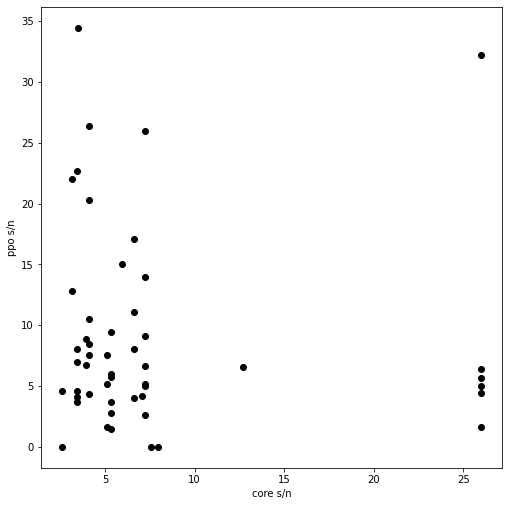

In [99]:
multiplicity_w51e_b6crit_b3fov = core_catdata_w51e_b6_b6crit_b3fov.multiplicity(hdrB3_w51e_hr,yso_xysource_w51e,
                                 almaimf_beam = beamb6_w51e_almaimf)


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
for i,ind in enumerate(multiplicity_w51e_b6crit_b3fov[2]):
    numppo = len(ind)
    coreind= multiplicity_w51e_b6crit_b3fov[1][i]
    ax1.scatter(core_snr_w51e_b6[coreind]*np.ones(numppo), ppo_snr_w51e_b6[ind],c='k')
ax1.set_xlabel('core s/n')
ax1.set_ylabel('ppo s/n')
  




0
1062.1483515381885 803.3868668251816
1062.1483515381885 803.3868668251816 8.578679710625183
(8, 9)
(1063, 801)
xcen,ycen, afwhm, bfwhm, peak_pixel, bkg, mad, snr 1063 1063 5.719119807083456 4.517946143943896 0.004771014 0.006293978309258819 0.0009498450599326122 25.91439628601 deg -1.6033816078699672
4
1066.3481954697693 835.1202208643933
1066.3481954697693 835.1202208643933 8.578679710625183
(8, 9)
(1065, 836)
xcen,ycen, afwhm, bfwhm, peak_pixel, bkg, mad, snr 1065 1065 5.719119807083456 4.517946143943896 0.006029662 0.006084052845835686 0.0011827037506311367 25.91439628601 deg -0.04598838492934593
5
1047.0815307776716 834.720126097349
1047.0815307776716 834.720126097349 8.578679710625183
(8, 9)
(1050, 837)
xcen,ycen, afwhm, bfwhm, peak_pixel, bkg, mad, snr 1050 1050 5.719119807083456 4.517946143943896 0.0056799133 0.006765239872038364 0.0014677746004691954 25.91439628601 deg -0.7394367914993494
6
1045.4148565691453 836.2534512352755
1045.4148565691453 836.2534512352755 8.5786797106

Text(0, 0.5, 'ciPPO s/n')

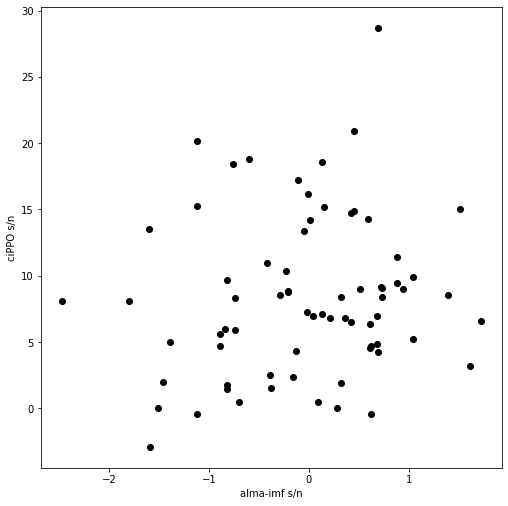

In [108]:

def get_peak_pos(data, xpos, ypos, beam, scale):
    """
    get the peak position within the beam sized-area
    """
    print(xpos,ypos,1.5*beam.major.value/scale.value)
    beam_region = EllipsePixelRegion(center=PixCoord(x=xpos, y=ypos),
                                       width=1.5*beam.major.value/scale.value,
                                        height=1.5*beam.minor.value/scale.value,
                                       angle=beam.pa)
    mask = beam_region.to_mask()
    data_in_cutout = mask.cutout(data)
    masked_data = data_in_cutout * mask.data
    maskbool = mask.data.astype('bool')
    print(masked_data.shape)
    peak = np.nanmax(masked_data)
    peakpos = np.unravel_index(np.nanargmax(masked_data), masked_data.shape)
    return (peakpos[0]+int(xpos)-int(1.5*beam.major.value/scale.value/2), peakpos[1]+int(ypos)-int(1.5*beam.minor.value/scale.value/2))


isincore_w51e_b3 = catalog_w51e_yso['inincore_b3fov'] 
isincore_w51n_b3 = catalog_w51n_yso['inincore_b3fov'] 
isoutcore_w51e_b3 = np.where(~catalog_w51e_yso['inincore_b3fov'])[0] 
isoutcore_w51n_b3 = np.where(~catalog_w51n_yso['inincore_b3fov'])[0] 


# For b6, need to combine isincore index with isoverlap index
isincore_w51e_b6 = np.intersect1d(np.where(catalog_w51e_yso['inincore_b3fov']), np.where(catalog_w51e_yso['is_overlap'])) 
isincore_w51n_b6 = np.intersect1d(np.where(catalog_w51n_yso['inincore_b3fov']), np.where(catalog_w51n_yso['is_overlap'])) 
isoutcore_w51e_b6 = np.intersect1d(np.where(~catalog_w51e_yso['inincore_b3fov']), np.where(catalog_w51e_yso['is_overlap'])) 
isoutcore_w51n_b6 = np.intersect1d(np.where(~catalog_w51n_yso['inincore_b3fov']), np.where(catalog_w51n_yso['is_overlap'])) 

iscore_ff_w51e = [41, 46, 48, 50, 51, 54, 56, 8, 9, 10, 85, 119, 25]
iscore_ff_w51n = [61, 3, 6, 7, 23, 29, 70, 71, 72, 52]



isoutcore_w51e_b3 = [i for i in list(isoutcore_w51e_b3) if i not in iscore_ff_w51e]
isoutcore_w51n_b3 = [i for i in list(isoutcore_w51n_b3) if i not in iscore_ff_w51n]
isoutcore_w51e_b6 = [i for i in list(isoutcore_w51e_b6) if i not in iscore_ff_w51e]
isoutcore_w51n_b6 = [i for i in list(isoutcore_w51n_b6) if i not in iscore_ff_w51n]


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
peakxy_almaimf_w51e_b6 = wcsB6_w51e_almaimf.wcs_world2pix(yso_xysource_w51e,0)

for ind in isoutcore_w51e_b3:
    print(ind)
    x = peakxy_almaimf_w51e_b6[ind,0]
    y= peakxy_almaimf_w51e_b6[ind,1]
    print(x,y)
    peakpos = get_peak_pos(image_almaimf_w51e_b6, x,y, beamb6_w51e_almaimf, scale_w51e_almaimf)
    print(peakpos)
    snr = get_snr(image_almaimf_w51e_b6, peakpos[0],peakpos[1], peakxy_almaimf_w51e_b6, beamb6_w51e_almaimf.major.value, beamb6_w51e_almaimf.minor.value, beamb6_w51e_almaimf.pa, wcsB6_w51e_almaimf, beamb6_w51e_almaimf, scale_w51e_almaimf)
    ax1.scatter(snr, ppo_snr_w51e_b6[ind],c='k')



ax1.set_xlabel('alma-imf s/n')
ax1.set_ylabel('ciPPO s/n')

In [ ]:
#ppo_snr_w51e_b6 = get_snr(image_b6_w51e, yso_xypix_w51e[:,0], yso_xypix_w51e[:,1],yso_xypix_w51e,w51e_b6_major/scale_w51e_b6_hr.value, w51e_b6_minor/scale_w51e_b6_hr.value, w51e_b6_pa, wcsB6_w51e_hr,beam_b6_w51e, scale_w51e_b6_hr) 
#def get_local_bkg(data, xcen, ycen, angle, peakxy_all, wcsNB, beam, pixel_scale, 
                  #inner_width=1, outer_width=2, inner_height=1, outer_height=2, issky=False, filter_bright_pixels=False, plot=False, n_expected_neighbor=10)
mad_snr_w51e_b6 = get_local_bkg(image_almaimf_w51e_b6, yso_xypix_w51e[:,0], yso_xypix_w51e[:,1], beam_b6_w51e.pa, yso_xypix_w51e, 
                                wcsB6_w51e_hr, beam_b6_w51e, scale_w51e_almaimf, inner_width=2*beamb6_w51e_almaimf.major.value/scale_w51e_almaimf.value, outer_width=3*beamb6_w51e_almaimf.major.value/scale_w51e_almaimf.value, inner_height=2*beamb6_w51e_almaimf.minor.value/scale_w51e_almaimf.value, outer_height=3*beamb6_w51e_almaimf.minor.value/scale_w51e_almaimf.value) 


for ind in isoutcore_w51e_b3:
    print(ind)
    x = peakxy_almaimf_w51e_b6[ind,0]
    y= peakxy_almaimf_w51e_b6[ind,1]
    print(x,y)
    peakpos = get_peak_pos(image_almaimf_w51e_b6, x,y, beamb6_w51e_almaimf, scale_w51e_almaimf)
    print(peakpos)
    bkg,mad = get_local_bkg(image_almaimf_w51e_b6, peakpos[0],peakpos[1], beamb6_w51e_almaimf.pa, peakxy_almaimf_w51e_b6, wcsB6_w51e_almaimf, beamb6_w51e_almaimf, scale_w51e_almaimf, inner_width=2*beamb6_w51e_almaimf.major.value/scale_w51e_almaimf.value, outer_width=3*beamb6_w51e_almaimf.major.value/scale_w51e_almaimf.value, inner_height=2*beamb6_w51e_almaimf.minor.value/scale_w51e_almaimf.value, outer_height=3*beamb6_w51e_almaimf.minor.value/scale_w51e_almaimf.value)
    ax1.scatter(mad, ppo_snr_w51e_b6[ind],c='k')



ax1.set_xlabel('alma-imf sigma')
ax1.set_ylabel('ciPPO sigma')